# Modelling Genre

## Preprocess the data

Tagging done with spacy=2.0.4. Only provide this dataset.

In [ ]:
import os
import json
import glob
import shutil

```python
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# limit to only three tags in Universal Part-of-Speech tagset
allowed = set('ADJ NOUN VERB'.split())

def preprocess(filenames, max_nb=None):
    #try:
    #    shutil.rmtree('books')
    #except FileNotFoundError:
    #    pass
    os.mkdir('books')
    
    books = {}
    for filename in filenames:
        comps = filename.split('/')
        genre, title = comps[-2:]
        
        if title in books:
            books[title].append(genre)
            continue
        else:
            books[title] = [genre]
        
        with open(filename, 'r') as f:
            try:
                text = f.read()
            except UnicodeDecodeError:
                continue
            tokens = nlp(text)
            if tokens:
                with open('books/' + title, 'w') as newf:
                    for t in tokens:
                        if t.pos_ in allowed and t.is_alpha and not t.is_stop:
                            newf.write(t.text.lower() + ' ')
        if max_nb and len(books) > max_nb:
            break
    
    with open('books_meta.json', 'w') as f:
        f.write(json.dumps(books, indent=4))
```

```python
import glob
path = '/Users/mike/GitRepos/potter/data/other/books_txt_full/*/*.txt'
filenames = sorted(list(glob.glob(path)))
preprocess(filenames)
```

## Inspect the data

Define a chunk yielder:

In [1]:
import glob
import random
RND = 12345
random.seed(RND)

class Chunker(object):
    def __init__(self, filenames, metadata, singles_only=False,
                 max_per_book=None, chunk_size=None):
        self.max_per_book = max_per_book
        self.chunk_size = chunk_size
        self.filenames = filenames
        self.meta = meta
        self.singles_only = singles_only
        
        # only collect genres during the first iteration
        self.first = True

    def __iter__(self):
        if self.first:
            self.genres = []
        for filename in self.filenames:
            title = os.path.basename(filename)
            current_genres = self.meta[title]
            if self.singles_only:
                if len(current_genres) > 1:
                    continue

            with open(filename, 'r') as f:
                try:
                    if self.max_per_book:
                        text = f.read(self.max_per_book)
                    else:
                        text = f.read()
                except:
                    continue
            tokens = text.split()
            for i in range(0, len(tokens), self.chunk_size):
                if self.first:
                    self.genres.append(current_genres)
                yield tokens[i:i + self.chunk_size]
        
        # stop collecting labels
        self.first = False

Set hyperparams:

In [57]:
n_features = 5000
n_topics = 300
n_top_words = 60
max_df = 0.5
min_df = 100
max_books = None
chunk_size = 1800
max_per_book = None

Make a split at the book level to avoid overfitting:

In [58]:
path = 'books/*.txt'
filenames = sorted(list(glob.glob(path)))

Collect metadata:

In [59]:
import json
with open('books_meta.json', 'r') as f:
    meta = json.loads(f.read())

In [60]:
random.seed(RND)
random.shuffle(filenames)
print(filenames[:10])
print(len(filenames))

['books/We_Can_Build_You.txt', 'books/PrinceCaspian.txt', 'books/Big_Girls_Do_06.txt', 'books/392303.txt', 'books/421926.txt', 'books/229689.txt', 'books/439376.txt', 'books/u3720.txt', 'books/u3906.txt', 'books/u4145.txt']
6800


Development truncation:

In [61]:
if max_books:
    filenames = filenames[:max_books]
print(len(filenames))

6800


Inspect genre overlap (in the entire corpus):

In [62]:
chunker = Chunker(filenames, metadata=meta, singles_only=False)

In [63]:
from collections import Counter
mults = Counter([len(genres) for title, genres in chunker.meta.items()])
print(mults)

Counter({1: 4257, 2: 2101, 3: 741, 4: 82, 5: 6})


How often do books have multiple genres?

Text(0.5,1,'Distribution of genres over books')

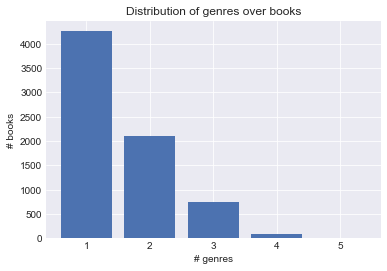

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
x, heights = list(zip(*mults.items()))
plt.bar(x=x, height=heights)
plt.xlabel('# genres')
plt.ylabel('# books')
plt.title('Distribution of genres over books')

How do genre labels cooccur?

['Adventure', 'Fantasy', 'Historical', 'Horror', 'Humor', 'Literature', 'Mystery', 'New_Adult', 'Other', 'Romance', 'Science_fiction', 'Teen', 'Themes', 'Thriller', 'Vampires', 'Young_Adult']


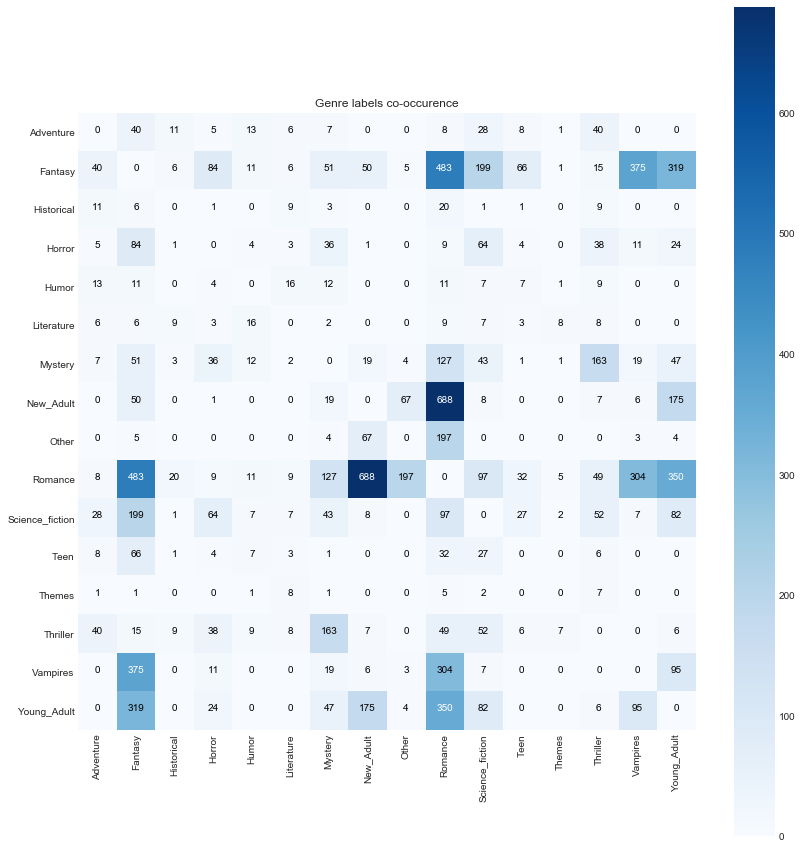

In [65]:
from itertools import combinations
import numpy as np
from itertools import product

G = sorted(set([label for labels in chunker.meta.values() for label in labels]))
C = np.zeros((len(G), len(G)), dtype=np.int64)
print(G)

for _, genres in chunker.meta.items():
    for a, b in combinations(genres, 2):
        C[G.index(a), G.index(b)] += 1
        C[G.index(b), G.index(a)] += 1

plt.figure(figsize=(12, 12))
ax = plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
plt.gca().grid(False)
plt.title('Genre labels co-occurence')
plt.colorbar()
tick_marks = np.arange(len(G))
plt.xticks(tick_marks, G, rotation=90)
plt.yticks(tick_marks, G)

thresh = C.max() / 2.
for i, j in product(range(C.shape[0]), range(C.shape[1])):
    plt.text(j, i, format(C[i, j], 'd'),
             horizontalalignment="center",
             color="white" if C[i, j] > thresh else "black")

plt.tight_layout()

How common is each genre?

Text(0.5,1,'Distribution of genres over books')

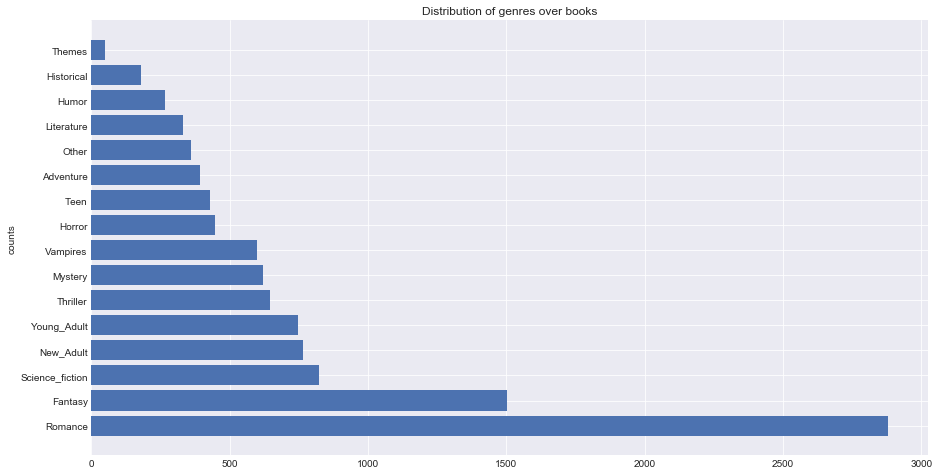

In [66]:
from operator import itemgetter
plt.figure(figsize=(15, 8))
G = Counter([label for labels in chunker.meta.values() for label in labels])
labels, heights = list(zip(*sorted(list(G.items()), key=itemgetter(1), reverse=True)))
plt.barh(y=range(len(heights)), width=heights)
plt.yticks(range(len(labels)), labels)
plt.ylabel('counts')
plt.title('Distribution of genres over books')

## Semantic modelling

### Topic modelling

In [67]:
chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_per_book=max_per_book)

In [68]:
import os
from sklearn.feature_extraction.text import CountVectorizer

def identity(x):
    return x

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)
print(X.shape)
print(vectorizer.get_feature_names()[:100])
print('nb of features:', len(vectorizer.get_feature_names()))

(98326, 5000)
['a', 'abandon', 'abandoned', 'abdomen', 'abilities', 'ability', 'abrupt', 'absence', 'absolute', 'absorbed', 'abuse', 'accent', 'accept', 'acceptance', 'accepted', 'accepting', 'access', 'accident', 'accompanied', 'accompany', 'accomplish', 'accomplished', 'according', 'account', 'accounts', 'accurate', 'accused', 'accustomed', 'ache', 'ached', 'achieve', 'aching', 'acknowledge', 'acknowledged', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'acts', 'actual', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'addressed', 'adds', 'adjust', 'adjusted', 'admire', 'admired', 'admiring', 'admit', 'admitted', 'adopted', 'adorable', 'adrenaline', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'advised', 'affair', 'affairs', 'affect', 'affected', 'affection', 'afford', 'afraid', 'afternoon', 'age', 'aged', 'agency', 'agent', 'agents', 'ages', 'aggressive', 'agitated', 'agony', 'agree', 'agreed', 'agr

In [69]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_ = transformer.fit_transform(X)

In [70]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=n_topics, random_state=RND, verbose=1, max_iter=50).fit(X_)

violation: 1.0
violation: 0.8412227133864387
violation: 3.064716940018332
violation: 2.437443265698119
violation: 2.0772825549811866
violation: 1.5638288845516715
violation: 1.1444754128498347
violation: 0.9274522218216542
violation: 0.7612455763643337
violation: 0.5991575220229579
violation: 0.4654004854332048
violation: 0.37614943477612217
violation: 0.30720055135568364
violation: 0.25477119104342943
violation: 0.2126060447190822
violation: 0.17779424909090982
violation: 0.151209542620454
violation: 0.13112314976087333
violation: 0.11642674149678146
violation: 0.10237060702347577
violation: 0.09185972827767028
violation: 0.08261038832450694
violation: 0.07480379124758015
violation: 0.068102329991648
violation: 0.06214852016454545
violation: 0.057193296386288624
violation: 0.053236137536233914
violation: 0.04996018501505986
violation: 0.047494925278125134
violation: 0.04568924377279725
violation: 0.04466800233107441
violation: 0.04457783642274944
violation: 0.04402389742758692
violati

### Reading tea leaves

In [71]:
import os
import shutil
from wordcloud import WordCloud
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

def top_words(model, feature_names, n_top_words):
    try:
        shutil.rmtree('clouds')
    except:
        pass
    os.mkdir('clouds')

    for topic_idx, topic in enumerate(model.components_):
        print('.', end='')
        topic = np.nan_to_num(topic)
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]

        weights = [topic[i] for i in topic.argsort()[:-n_top_words-1:-1]]

        freqs = {wo: we for wo, we in zip(words, weights)}
        wordcloud = WordCloud(normalize_plurals=False,
                                  background_color='white',
                                  colormap='inferno_r',
                                  width=800,
                                  height=400)
        wordcloud = wordcloud.generate_from_frequencies(freqs)
        plt.imsave('clouds/'+str(topic_idx) + '.tiff',
                          wordcloud, dpi=1000)

feature_names = vectorizer.get_feature_names()
info = top_words(nmf, feature_names, 50)

............................................................................................................................................................................................................................................................................................................

In [19]:
#!pip install pyldavis
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
pyLDAvis.sklearn.prepare(nmf, X, vectorizer)
# student assignment: provide short interpretative labels for each topic

violation: 1.0
violation: 0.3666424118033578
violation: 0.16970764857863382
violation: 0.04499782205332702
violation: 0.017572101248036168
violation: 0.009008986471659054
violation: 0.0035471541583663798
violation: 0.0013428758822797771
violation: 0.0006880310319274123
violation: 0.0003420888665643703
violation: 0.0001420864383597235
violation: 6.092729703441402e-05
Converged at iteration 12


//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/sklearn.py:26: RuntimeWarning: invalid value encountered in true_divide
  return dists / dists.sum(axis=1)[:, None]
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
//anaconda/envs/clean36/lib/python3.6/site-packages/pyLDAvis/_prepare.p

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
114    3.350362        1       1 -0.038509  0.079995
101    2.291615        1       2  0.211477 -0.012324
119    2.236918        1       3  0.238158  0.044367
124    2.207238        1       4  0.063648 -0.013246
132    2.134059        1       5  0.179972 -0.006295
147    2.073323        1       6  0.068974 -0.132333
141    1.871770        1       7  0.004918 -0.106283
0      1.768976        1       8  0.043361  0.165856
133    1.732097        1       9  0.061091 -0.003610
107    1.664125        1      10  0.127916  0.172575
4      1.588965        1      11 -0.188305 -0.109118
115    1.501563        1      12  0.112635 -0.052346
103    1.464804        1      13  0.183724  0.146618
3      1.433875        1      14 -0.067833  0.019203
117    1.401943        1      15  0.107452  0.203259
1      1.387100        1      16  0.025858 -0.027216
109    1.370815        1      17  0.177131 -0.108390
127    1.353578        1      18 -0.068129 -0.133501
116    1.249480        1      19  0.040844  0.116284
144    1.234819        1      20 -0.192674  0.026656
142    1.234336        1      21 -0.115391 -0.052289
99     1.222017        1      22  0.011062  0.008630
130    1.163100        1      23  0.127111 -0.108186
140    1.138601        1      24  0.066738 -0.083229
125    1.127108        1      25 -0.090666  0.089395
18     1.090305        1      26  0.028002  0.160753
137    1.026503        1      27  0.073566 -0.195443
106    1.016711        1      28  0.033589 -0.160713
104    1.011123        1      29 -0.164644  0.160418
13     1.007889        1      30 -0.042524 -0.214611
...         ...      ...     ...       ...       ...
91     0.256450        1     121  0.003685 -0.077111
52     0.249847        1     122  0.033711  0.208377
16     0.248128        1     123  0.007623 -0.154919
96     0.247869        1     124 -0.096405 -0.102369
138    0.243144        1     125 -0.072201  0.101219
31     0.232882        1     126  0.075308 -0.082321
77     0.226828        1     127  0.062342  0.108587
20     0.226823        1     128 -0.076578  0.119599
38     0.225544        1     129 -0.119786 -0.206769
76     0.221593        1     130  0.017716  0.259353
73     0.220484        1     131  0.098731 -0.117540
17     0.218998        1     132  0.040643 -0.041249
40     0.210783        1     133 -0.211153 -0.083540
29     0.200159        1     134 -0.079498  0.116326
10     0.188995        1     135  0.088982 -0.097291
46     0.179481        1     136 -0.146603 -0.108559
28     0.159467        1     137  0.009476  0.223940
81     0.159026        1     138 -0.156377 -0.133278
70     0.158698        1     139 -0.120740  0.010561
57     0.152142        1     140 -0.131362 -0.042124
43     0.141211        1     141  0.182628  0.067079
11     0.138256        1     142  0.026923  0.091793
26     0.137260        1     143 -0.024275 -0.056621
21     0.129843        1     144 -0.181755 -0.081618
33     0.108848        1     145  0.044839  0.059863
34     0.095669        1     146  0.181033  0.105674
84     0.089043        1     147  0.012572 -0.013102
36     0.088761        1     148  0.004893 -0.057200
65     0.073966        1     149  0.037831  0.024148
15     0.040364        1     150 -0.005634 -0.110975

[150 rows x 5 columns], topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
3028   Default  485651.000000     parents  485651.000000  30.0000  30.0000
492    Default  393700.000000        boys  393700.000000  29.0000  29.0000
3584   Default  414017.000000        ring  414017.000000  28.0000  28.0000
4055   Default  384606.000000         son  384606.000000  27.0000  27.0000
490    Default  282782.000000         boy  282782.000000  26.0000  26.0000
4893   Default  240785.000000        will  240785.000000  25.0000  25

## Apply to HP

```python
from lxml import etree
from collections import OrderedDict

def load_potter(fn):
    series = etree.parse(fn)
    HP = OrderedDict()
    for book in series.iterfind('.//book'):
        book_title = book.attrib['title']
        #print(book_title)
        HP[book_title] = OrderedDict()
        
        for chapter in book.iterfind('.//chapter'):
            chapter_title = chapter.attrib['title']
            #print('   ', chapter_title)
            HP[book_title][chapter_title] = []
            
            for paragraph in chapter.iterfind('.//p'):
                text = ''.join([x for x in paragraph.itertext()])
                HP[book_title][chapter_title].append(text)
    return HP

US_HP = load_potter('../preprocessing/simple_potter_us.xml')
```

```python
try:
    shutil.rmtree('hp')
except FileNotFoundError:
    pass
os.mkdir('hp')
```

```python
cnt = 0
lens = []
for book_title in US_HP:
    for idx, chap_title in enumerate(US_HP[book_title]):
        cnt += 1
        id_ = (4 - len(str(cnt))) * '0' + str(cnt)
        filename = 'hp/' + id_ + '+' + book_title.replace(' ', '_') + '+' + chap_title.replace(' ', '_') + '.txt'
        with open(filename, 'w') as newf:
            chap_text = ' '.join(US_HP[book_title][chap_title])
            token_cnt = 0
            for t in nlp(chap_text):
                if t.pos_ in allowed and t.is_alpha and not t.is_stop:
                    newf.write(t.text.lower() + ' ')
                    token_cnt += 1
        lens.append(token_cnt)    
print('mean len:', np.mean(lens))
```

In [87]:
import pandas as pd
nmf.verbose = 0
df = pd.DataFrame(columns=['book', 'chapter'])
filenames = sorted(glob.glob('hp/*.txt'), key=lambda v: int(v.split('+')[0].split('/')[1]))
texts = []
for filename in filenames:
    with open(filename, 'r') as f:
        tokens = f.read().split()
    cnt, title, chap = os.path.basename(filename).replace('.txt', '').split('+')
    texts.append(tokens)
    df.loc[len(df)] = [title, chap]

scores = nmf.transform(transformer.transform(vectorizer.transform(texts)))
print(scores.shape)

(397, 300)


In [88]:
df_scores = pd.DataFrame(scores, columns=[f't{i+1}' for i in range(n_topics)])
df = df.join(df_scores)
df

book  \
0    Harry_Potter_and_the_Sorcerer's_Stone   
1    Harry_Potter_and_the_Sorcerer's_Stone   
2    Harry_Potter_and_the_Sorcerer's_Stone   
3    Harry_Potter_and_the_Sorcerer's_Stone   
4    Harry_Potter_and_the_Sorcerer's_Stone   
5    Harry_Potter_and_the_Sorcerer's_Stone   
6    Harry_Potter_and_the_Sorcerer's_Stone   
7    Harry_Potter_and_the_Sorcerer's_Stone   
8    Harry_Potter_and_the_Sorcerer's_Stone   
9    Harry_Potter_and_the_Sorcerer's_Stone   
10   Harry_Potter_and_the_Sorcerer's_Stone   
11   Harry_Potter_and_the_Sorcerer's_Stone   
12   Harry_Potter_and_the_Sorcerer's_Stone   
13   Harry_Potter_and_the_Sorcerer's_Stone   
14   Harry_Potter_and_the_Sorcerer's_Stone   
15   Harry_Potter_and_the_Sorcerer's_Stone   
16   Harry_Potter_and_the_Sorcerer's_Stone   
17   Harry_Potter_and_the_Sorcerer's_Stone   
18   Harry_Potter_and_the_Sorcerer's_Stone   
19   Harry_Potter_and_the_Sorcerer's_Stone   
20   Harry_Potter_and_the_Sorcerer's_Stone   
21   Harry_Potter_and_the_Sorcerer's_Stone   
22   Harry_Potter_and_the_Sorcerer's_Stone   
23   Harry_Potter_and_the_Sorcerer's_Stone   
24   Harry_Potter_and_the_Sorcerer's_Stone   
25   Harry_Potter_and_the_Sorcerer's_Stone   
26   Harry_Potter_and_the_Sorcerer's_Stone   
27   Harry_Potter_and_the_Sorcerer's_Stone   
28   Harry_Potter_and_the_Sorcerer's_Stone   
29   Harry_Potter_and_the_Sorcerer's_Stone   
..                                     ...   
367   Harry_Potter_and_the_Deathly_Hallows   
368   Harry_Potter_and_the_Deathly_Hallows   
369   Harry_Potter_and_the_Deathly_Hallows   
370   Harry_Potter_and_the_Deathly_Hallows   
371   Harry_Potter_and_the_Deathly_Hallows   
372   Harry_Potter_and_the_Deathly_Hallows   
373   Harry_Potter_and_the_Deathly_Hallows   
374   Harry_Potter_and_the_Deathly_Hallows   
375   Harry_Potter_and_the_Deathly_Hallows   
376   Harry_Potter_and_the_Deathly_Hallows   
377   Harry_Potter_and_the_Deathly_Hallows   
378   Harry_Potter_and_the_Deathly_Hallows   
379   Harry_Potter_and_the_Deathly_Hallows   
380   Harry_Potter_and_the_Deathly_Hallows   
381   Harry_Potter_and_the_Deathly_Hallows   
382   Harry_Potter_and_the_Deathly_Hallows   
383   Harry_Potter_and_the_Deathly_Hallows   
384   Harry_Potter_and_the_Deathly_Hallows   
385   Harry_Potter_and_the_Deathly_Hallows   
386   Harry_Potter_and_the_Deathly_Hallows   
387   Harry_Potter_and_the_Deathly_Hallows   
388   Harry_Potter_and_the_Deathly_Hallows   
389   Harry_Potter_and_the_Deathly_Hallows   
390   Harry_Potter_and_the_Deathly_Hallows   
391   Harry_Potter_and_the_Deathly_Hallows   
392   Harry_Potter_and_the_Deathly_Hallows   
393   Harry_Potter_and_the_Deathly_Hallows   
394   Harry_Potter_and_the_Deathly_Hallows   
395   Harry_Potter_and_the_Deathly_Hallows   
396   Harry_Potter_and_the_Deathly_Hallows   

                                               chapter        t1        t2  \
0                                    THE_BOY_WHO_LIVED  0.009784  0.000000   
1                                  THE_VANISHING_GLASS  0.000000  0.000000   
2                                  THE_VANISHING_GLASS  0.000000  0.000000   
3                              THE_LETTERS_FROM_NO_ONE  0.005826  0.000000   
4                              THE_LETTERS_FROM_NO_ONE  0.005826  0.000000   
5                               THE_KEEPER_OF_THE_KEYS  0.000000  0.000318   
6                               THE_KEEPER_OF_THE_KEYS  0.000000  0.000318   
7                                         DIAGON_ALLEY  0.000000  0.000191   
8                                         DIAGON_ALLEY  0.000000  0.000191   
9    THE_JOURNEY_FROM_PLATFORM_NINE_AND_THREE-QUARTERS  0.004774  0.000188   
10   THE_JOURNEY_FROM_PLATFORM_NINE_AND_THREE-QUARTERS  0.004774  0.000188   
11                                     THE_SORTING_HAT  0.002878  0.000570   
12                                     THE_SORTING_HAT  0.002878  0.000570   
13                                  THE_POTIONS_MASTER  0.003988  0.000363   
14             

In [100]:
from scipy.stats import kendalltau
ranks = range(1, len(df.index)+1)
tau_scores = []
for col in [f't{i+1}' for i in range(n_topics)]:
    tau, p = kendalltau(ranks, df[col].tolist())
    tau_scores.append((col, tau))

In [160]:
tau_scores.sort(key=itemgetter(1))
nb = 10
top, bottom = tau_scores[:nb], tau_scores[-nb:]

Plot at individual chapter level:

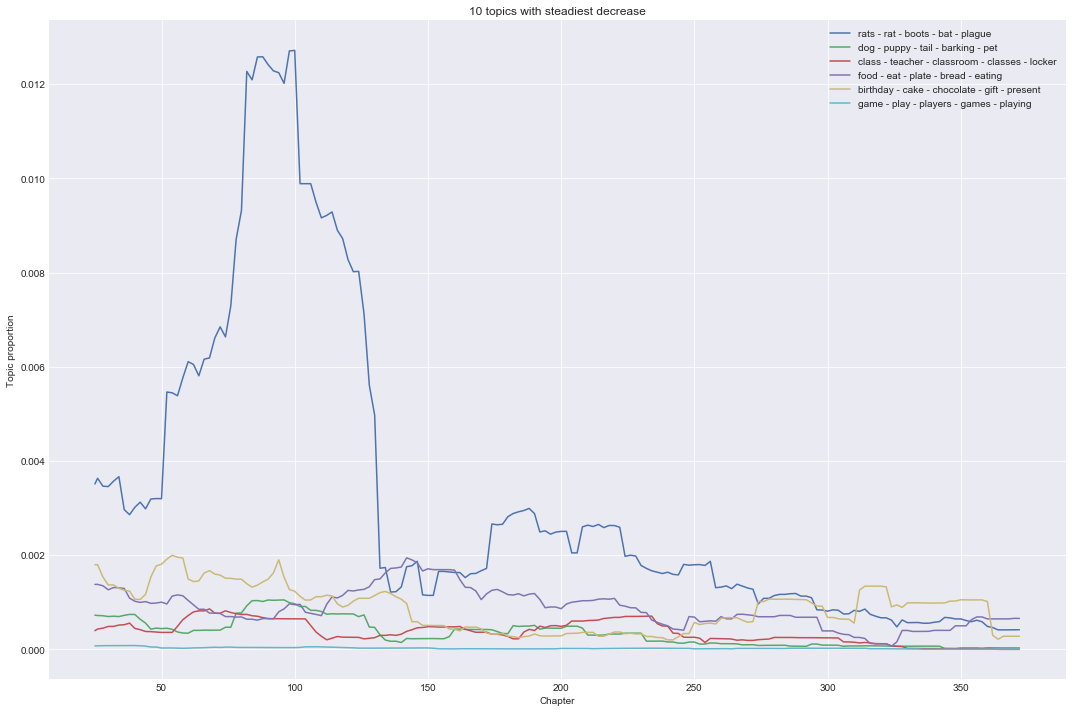

In [161]:
feature_names = vectorizer.get_feature_names()
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    df[feat].rolling(window=50, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest decrease')
plt.tight_layout()
plt.legend()

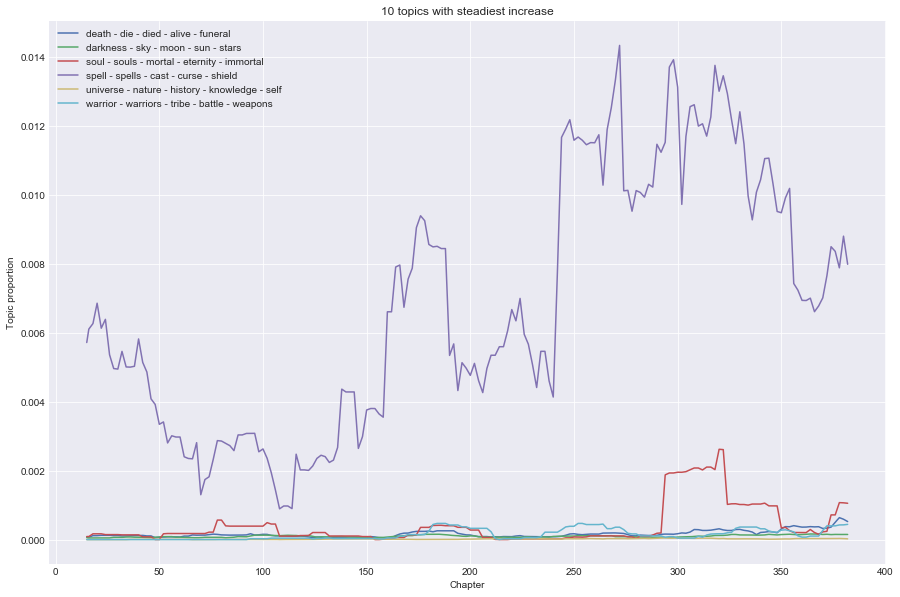

In [162]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    df[feat].rolling(window=30, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend()

Plot at book level:

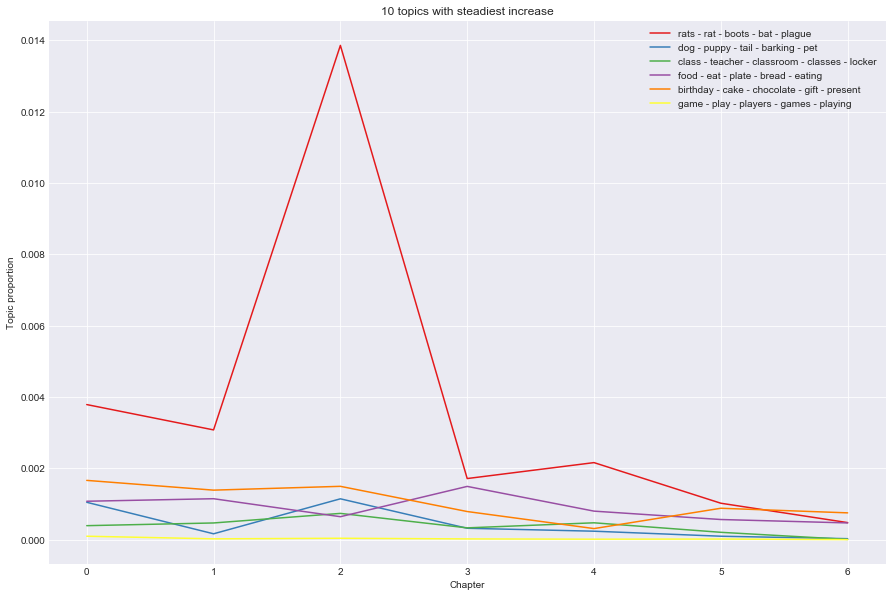

In [163]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    av = df.groupby('book', sort=False)[feat].mean()
    plt.plot(range(len(av)), av, label=label, c=col)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend()

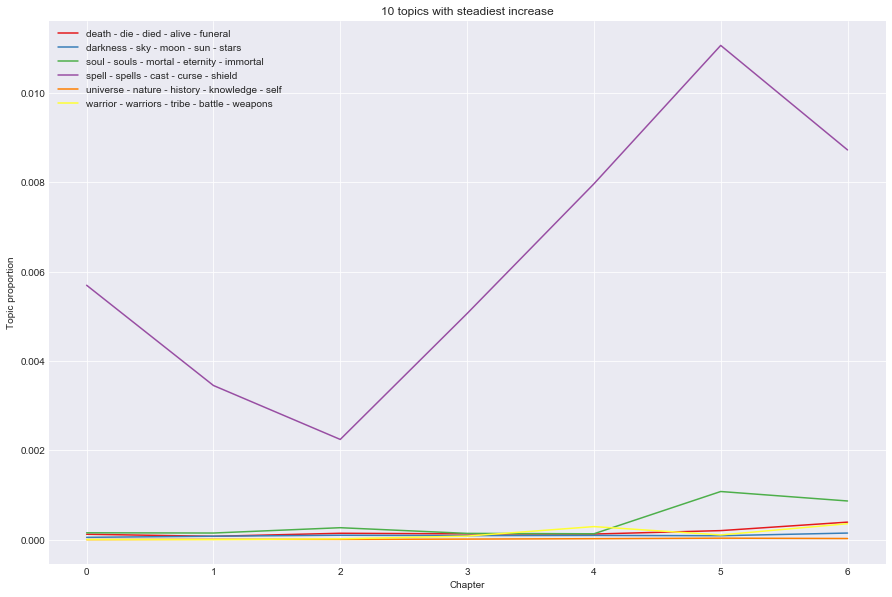

In [164]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    av = df.groupby('book', sort=False)[feat].mean()
    plt.plot(range(len(av)), av, label=label, c=col)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend()

## Prepare single-label classification task

In [ ]:
from sklearn.model_selection import train_test_split
trainfiles, testfiles = train_test_split(filenames,
                                         train_size=.9,
                                         test_size=.1,
                                         shuffle=True,
                                         random_state=RND)
print(len(trainfiles))
print(len(testfiles))

In [ ]:
train_chunks = Chunker(trainfiles,
                       singles_only=True,
                       chunk_size=chunk_size,
                       max_per_book=max_per_book,
                       metadata=meta)
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)

train_X = vectorizer.fit_transform(train_chunks)
train_genres = train_chunks.genres

print(vectorizer.get_feature_names()[:100])
print('nb of features:', len(vectorizer.get_feature_names()))

In [ ]:
test_chunks = Chunker(testfiles, metadata=meta,
                      singles_only=True,
                      chunk_size=chunk_size,
                      max_per_book=max_per_book)
test_X = vectorizer.transform(test_chunks)
test_genres = test_chunks.genres
print(test_X.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformer.fit(train_X)

train_X_norm = transformer.transform(train_X).toarray()
test_X_norm = transformer.transform(test_X).toarray()

print(train_X_norm.shape)
print(test_X_norm.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit([t[0] for t in train_genres])
train_ints = encoder.transform([t[0] for t in train_genres])
test_ints = encoder.transform([t[0] for t in test_genres])
print(train_ints.shape)
print(test_ints.shape)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()
train_y = binarizer.fit_transform(train_ints)
test_y = binarizer.transform(test_ints)
print(train_y.shape)
print(test_y.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dropout(0.5, input_shape=(train_X_norm.shape[1],)))
model.add(Dense(units=len(encoder.classes_)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.fit(train_X_norm, train_y,
          validation_split=0.1,
          epochs=10, batch_size=128)

First test on train:

In [ ]:
from pandas import DataFrame
from IPython.display import HTML
HTML(DataFrame(train_y, columns=encoder.classes_).head(10).to_html())

In [ ]:
train_pred = model.predict(train_X_norm)
HTML(DataFrame(train_pred, columns=encoder.classes_).head(10).to_html())

In [ ]:
train_pred_int = model.predict_classes(train_X_norm)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
acc = accuracy_score(train_pred_int, train_ints)
f1 = f1_score(train_pred_int, train_ints, average='weighted')
print('accuracy: ', acc)
print('f1 score: ', f1)

Now move to test:

In [ ]:
test_pred_ints = model.predict_classes(test_X_norm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_pred_ints, test_ints, target_names=encoder.classes_))

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_pred_ints, test_ints)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(20, 20))
plot_confusion_matrix(cnf_matrix, classes=encoder.classes_, normalize=False,
                      title='Normalized confusion matrix')

In [ ]:
W = model.get_weights()[0].T
print(W.shape)
vocab = np.array(vectorizer.get_feature_names())
print(vocab.shape)
for genre_idx, genre in enumerate(encoder.classes_):
    top_idxs = np.argsort(W[genre_idx, :])[::-1][:10]
    top_words = vocab[top_idxs]
    print(genre, ':', ' - '.join(top_words))

## Multilabel setup

In [ ]:
train_chunks = Chunker(trainfiles,
                       singles_only=True,
                       chunk_size=chunk_size,
                       max_per_book=max_per_book,
                       metadata=meta)
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)

train_X = vectorizer.fit_transform(train_chunks)
train_genres = train_chunks.genres



print(vectorizer.get_feature_names()[:100])
print('nb of features:', len(vectorizer.get_feature_names()))

In [ ]:
test_chunks = Chunker(testfiles, meta,
                      singles_only=False,
                      chunk_size=chunk_size,
                      max_per_book=max_per_book)
test_X = vectorizer.transform(test_chunks)
print(test_X.shape)

In [ ]:
transformer = TfidfTransformer()
transformer.fit(train_X)

train_X_norm = transformer.transform(train_X)
test_X_norm = transformer.transform(test_X)

print(train_X_norm.shape)
print(test_X_norm.shape)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
encoder = MultiLabelBinarizer()
train_Y = encoder.fit_transform(train_chunks.genres)
test_Y = encoder.transform(test_chunks.genres)
print(train_Y.shape)
print(test_Y.shape)

In [ ]:
HTML(DataFrame(test_Y, columns=encoder.classes_).head(20).to_html())

In [ ]:
model = Sequential()
model.add(Dense(units=len(encoder.classes_),
                activation='sigmoid',
                input_dim=train_X_norm.shape[1]))
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])

model.fit(train_X_norm, train_Y,
          validation_split=0.1,
          epochs=1, batch_size=128)

In [ ]:
test_pred_Y = model.predict(test_X_norm)
HTML(DataFrame(test_pred_Y, columns=encoder.classes_).head(20).to_html())

In [ ]:
test_pred_int = np.zeros(test_pred_Y.shape, dtype='int32')
test_pred_int[test_pred_Y > 0.5] = 1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
acc = accuracy_score(test_pred_int, test_Y)
f1 = f1_score(test_pred_int, test_Y, average='weighted')
hamming = hamming_loss(test_pred_int, test_Y)
print('accuracy: ', acc)
print('f1 score: ', f1)
print('hamming loss: ', hamming)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_pred_int, test_Y, target_names=encoder.classes_))

## Applying to HP